# Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from prettytable import PrettyTable

# Load data

In [2]:
data_file_name = 'dataset.xlsx'
data_dir_path = '.'
data_file_path = os.path.join(data_dir_path, data_file_name)
print(data_file_path)
# Load 'data' spreadsheet
df = pd.read_excel(open(data_file_path, 'rb'), sheetname='data', header=1)

print(df.head())
print(df.columns)

./dataset.xlsx
        Date    KOSPI  KOSDAQ  Average_Temperature  Lowest_Temperature  \
0 2016-01-04  1918.76  677.79                 10.4                 7.6   
1 2016-01-05  1930.53  684.07                  5.3                 3.2   
2 2016-01-06  1925.43  687.27                  4.8                 1.8   
3 2016-01-07  1904.33  679.66                  3.9                 1.1   
4 2016-01-08  1917.62  682.56                  2.5                -0.5   

   Highest_temperature  Precipitation  Average_Wind_Speed  \
0                 15.2            0.0                 2.7   
1                  8.1            0.2                 3.1   
2                  9.9            0.0                 2.9   
3                  8.5            0.0                 2.7   
4                  6.9            0.0                 2.9   

   Average_Relative_humidity  Daylight_Hours  Cloud_Cover  Duration_of_Fog  \
0                       46.3             8.6          0.8              0.0   
1                

# Preprocessing - fill in missing values

In [3]:
def fill_in_missing_data(data, window_size):
    num_of_data = len(data)
    indices = np.where(np.isnan(data))[0]

    for i in indices:
        values = []
        distances = []
        for j in range(1,window_size+1):
            if i-j >= 0 and not np.isnan(data[i-j]):
                values.append(data[i-j])
                distances.append(j)
            if i+j < num_of_data and not np.isnan(data[i+j]):
                values.append(data[i+j])
                distances.append(j)

        values = np.array(values)
        distances = np.array(distances)
        inverse_distances = 1.0 / distances
        weights = inverse_distances / np.sum(inverse_distances)
        filling_value = np.sum(np.multiply(values, weights))
        data[i] = filling_value
    return data

def test_fill_in_missing_data(data, window_size):
    modified_data = fill_in_missing_data(np.copy(data), 3)
    plt.plot(modified_data)
    plt.show()
#     data[np.where(np.isnan(data))] = 0
#     plt.plot(data)
#     plt.ylim(1800, 2100)
#     plt.show()
    

In [4]:
kospi = df['KOSPI']
kosdaq = df['KOSDAQ']

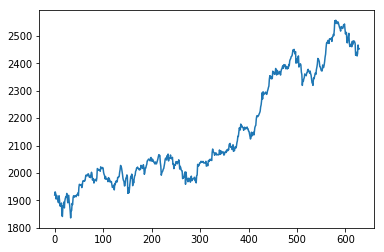

In [5]:
test_fill_in_missing_data(np.copy(kospi),3)

In [6]:
# fill in missing values
df['KOSPI'] = fill_in_missing_data(np.copy(kospi), 3)
df['KOSDAQ'] = fill_in_missing_data(np.copy(kosdaq), 3)

# LSTM

In [7]:
def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [8]:
df.head()

,Date,KOSPI,KOSDAQ,Average_Temperature,Lowest_Temperature,Highest_temperature,Precipitation,Average_Wind_Speed,Average_Relative_humidity,Daylight_Hours,Cloud_Cover,Duration_of_Fog,Revenue,Fitness,Sports_Center,Gym,Diet,Body,Busan_Sports_Center,Busan_Gym
0,2016-01-04,1918.76,677.79,10.4,7.6,15.2,0.0,2.7,46.3,8.6,0.8,0.0,1200000,1.70885,0.66053,15.25185,69.49203,1.70459,74.50980,54.90196
1,2016-01-05,1930.53,684.07,5.3,3.2,8.1,0.2,3.1,40.9,0.0,7.0,0.0,900000,1.68328,0.54120,11.19918,58.96616,1.35089,20.91503,43.13725
2,2016-01-06,1925.43,687.27,4.8,1.8,9.9,0.0,2.9,34.5,7.7,5.6,0.0,950000,1.99437,0.45597,10.07841,62.38387,1.30827,25.49019,39.86928
3,2016-01-07,1904.33,679.66,3.9,1.1,8.5,0.0,2.7,47.3,8.6,0.9,0.0,880000,1.65771,0.47728,8.82553,63.78164,2.01142,22.87581,42.48366
4,2016-01-08,1917.62,682.56,2.5,-0.5,6.9,0.0,2.9,44.1,9.1,0.8,0.0,450000,1.35941,0.41336,7.26583,57.66641,1.44464,16.99346,24.83660


In [9]:
variable_list = ['Average_Temperature', 'Revenue']
target_variable = ['Revenue']

In [10]:
df_subset = df.loc[:, variable_list]
df_subset_scaled = df_subset.apply(MinMaxScaler, axis=0)
print(df_subset_scaled.head())

   Average_Temperature   Revenue
0             0.388889  0.255834
1             0.239766  0.191608
2             0.225146  0.202312
3             0.198830  0.187326
4             0.157895  0.095269


In [11]:
seq_len = 5
data_dim = len(variable_list)
output_dim = 1
hidden_dim = 10
iterations = 2000

In [12]:
dataX = []
dataY = []
for i in range(df_subset_scaled.shape[0] - seq_len):
    _x = df_subset_scaled.loc[i:i+seq_len-1, variable_list].values
    _y = df_subset_scaled.loc[i+seq_len, target_variable].values
    print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

(array([[0.38888889, 0.25583387],
       [0.23976608, 0.19160779],
       [0.2251462 , 0.20231214],
       [0.19883041, 0.18732605],
       [0.15789474, 0.09526868]]), '->', array([0.23442518]))
(array([[0.23976608, 0.19160779],
       [0.2251462 , 0.20231214],
       [0.19883041, 0.18732605],
       [0.15789474, 0.09526868],
       [0.19590643, 0.23442518]]), '->', array([0.13808606]))
(array([[0.2251462 , 0.20231214],
       [0.19883041, 0.18732605],
       [0.15789474, 0.09526868],
       [0.19590643, 0.23442518],
       [0.21637427, 0.13808606]]), '->', array([0.4485121]))
(array([[0.19883041, 0.18732605],
       [0.15789474, 0.09526868],
       [0.19590643, 0.23442518],
       [0.21637427, 0.13808606],
       [0.15789474, 0.4485121 ]]), '->', array([0.57696425]))
(array([[0.15789474, 0.09526868],
       [0.19590643, 0.23442518],
       [0.21637427, 0.13808606],
       [0.15789474, 0.4485121 ],
       [0.12865497, 0.57696425]]), '->', array([0.26653821]))
(array([[0.19590643, 0.234

(array([[0.24853801, 0.03232712],
       [0.1871345 , 0.26047955],
       [0.23391813, 0.23463926],
       [0.30701754, 0.0583815 ],
       [0.30994152, 0.03189895]]), '->', array([0.05823164]))
(array([[0.1871345 , 0.26047955],
       [0.23391813, 0.23463926],
       [0.30701754, 0.0583815 ],
       [0.30994152, 0.03189895],
       [0.3245614 , 0.05823164]]), '->', array([0.00278313]))
(array([[0.23391813, 0.23463926],
       [0.30701754, 0.0583815 ],
       [0.30994152, 0.03189895],
       [0.3245614 , 0.05823164],
       [0.45321637, 0.00278313]]), '->', array([0.53864269]))
(array([[0.30701754, 0.0583815 ],
       [0.30994152, 0.03189895],
       [0.3245614 , 0.05823164],
       [0.45321637, 0.00278313],
       [0.45614035, 0.53864269]]), '->', array([0.07385999]))
(array([[0.30994152, 0.03189895],
       [0.3245614 , 0.05823164],
       [0.45321637, 0.00278313],
       [0.45614035, 0.53864269],
       [0.47368421, 0.07385999]]), '->', array([0.12417041]))
(array([[0.3245614 , 0.05

(array([[0.60233918, 0.1522158 ],
       [0.57894737, 0.50845643],
       [0.64035088, 0.48126739],
       [0.54093567, 0.11004068],
       [0.62865497, 0.05587669]]), '->', array([0.67030614]))
(array([[0.57894737, 0.50845643],
       [0.64035088, 0.48126739],
       [0.54093567, 0.11004068],
       [0.62865497, 0.05587669],
       [0.68421052, 0.67030614]]), '->', array([0.42967245]))
(array([[0.64035088, 0.48126739],
       [0.54093567, 0.11004068],
       [0.62865497, 0.05587669],
       [0.68421052, 0.67030614],
       [0.69005848, 0.42967245]]), '->', array([0.32926568]))
(array([[0.54093567, 0.11004068],
       [0.62865497, 0.05587669],
       [0.68421052, 0.67030614],
       [0.69005848, 0.42967245],
       [0.69883041, 0.32926568]]), '->', array([0.31642047]))
(array([[0.62865497, 0.05587669],
       [0.68421052, 0.67030614],
       [0.69005848, 0.42967245],
       [0.69883041, 0.32926568],
       [0.69590643, 0.31642047]]), '->', array([0.14964676]))
(array([[0.68421052, 0.67

(array([[0.91812865, 0.15970884],
       [0.92397661, 0.05559837],
       [0.92690058, 0.03189895],
       [0.89766082, 0.20745022],
       [0.88304093, 0.07985442]]), '->', array([0.14044102]))
(array([[0.92397661, 0.05559837],
       [0.92690058, 0.03189895],
       [0.89766082, 0.20745022],
       [0.88304093, 0.07985442],
       [0.88304093, 0.14044102]]), '->', array([0.09398416]))
(array([[0.92690058, 0.03189895],
       [0.89766082, 0.20745022],
       [0.88304093, 0.07985442],
       [0.88304093, 0.14044102],
       [0.9122807 , 0.09398416]]), '->', array([0.33932777]))
(array([[0.89766082, 0.20745022],
       [0.88304093, 0.07985442],
       [0.88304093, 0.14044102],
       [0.9122807 , 0.09398416],
       [0.90643275, 0.33932777]]), '->', array([0.01691287]))
(array([[0.88304093, 0.07985442],
       [0.88304093, 0.14044102],
       [0.9122807 , 0.09398416],
       [0.90643275, 0.33932777],
       [0.92982456, 0.01691287]]), '->', array([0.45793192]))
(array([[0.88304093, 0.14

(array([[0.59356725, 0.1478313 ],
       [0.61988304, 0.0768572 ],
       [0.56432748, 0.1046885 ],
       [0.55847953, 0.23114965],
       [0.62573099, 0.19374866]]), '->', array([0.07578677]))
(array([[0.61988304, 0.0768572 ],
       [0.56432748, 0.1046885 ],
       [0.55847953, 0.23114965],
       [0.62573099, 0.19374866],
       [0.61695906, 0.07578677]]), '->', array([0.10483836]))
(array([[0.56432748, 0.1046885 ],
       [0.55847953, 0.23114965],
       [0.62573099, 0.19374866],
       [0.61695906, 0.07578677],
       [0.5994152 , 0.10483836]]), '->', array([0.07214729]))
(array([[0.55847953, 0.23114965],
       [0.62573099, 0.19374866],
       [0.61695906, 0.07578677],
       [0.5994152 , 0.10483836],
       [0.54093567, 0.07214729]]), '->', array([0.01883965]))
(array([[0.62573099, 0.19374866],
       [0.61695906, 0.07578677],
       [0.5994152 , 0.10483836],
       [0.54093567, 0.07214729],
       [0.51461988, 0.01883965]]), '->', array([0.81203168]))
(array([[0.61695906, 0.07

(array([[0.33918129, 0.04795547],
       [0.35672515, 0.31535003],
       [0.29824561, 0.21515735],
       [0.1871345 , 0.29008778],
       [0.11695906, 0.16591736]]), '->', array([0.1145365]))
(array([[0.35672515, 0.31535003],
       [0.29824561, 0.21515735],
       [0.1871345 , 0.29008778],
       [0.11695906, 0.16591736],
       [0.19883041, 0.1145365 ]]), '->', array([0.25733248]))
(array([[0.29824561, 0.21515735],
       [0.1871345 , 0.29008778],
       [0.11695906, 0.16591736],
       [0.19883041, 0.1145365 ],
       [0.12865497, 0.25733248]]), '->', array([0.18531364]))
(array([[0.1871345 , 0.29008778],
       [0.11695906, 0.16591736],
       [0.19883041, 0.1145365 ],
       [0.12865497, 0.25733248],
       [0.01461988, 0.18531364]]), '->', array([0.49576108]))
(array([[0.11695906, 0.16591736],
       [0.19883041, 0.1145365 ],
       [0.12865497, 0.25733248],
       [0.01461988, 0.18531364],
       [0.04093567, 0.49576108]]), '->', array([0.71933205]))
(array([[0.19883041, 0.114

(array([[0.34795322, 0.06679512],
       [0.39473684, 0.12695354],
       [0.41520468, 0.08028259],
       [0.39766082, 0.03532434],
       [0.35380117, 0.12888033]]), '->', array([0.02954399]))
(array([[0.39473684, 0.12695354],
       [0.41520468, 0.08028259],
       [0.39766082, 0.03532434],
       [0.35380117, 0.12888033],
       [0.35087719, 0.02954399]]), '->', array([0.37593663]))
(array([[0.41520468, 0.08028259],
       [0.39766082, 0.03532434],
       [0.35380117, 0.12888033],
       [0.35087719, 0.02954399],
       [0.42397661, 0.37593663]]), '->', array([0.18732605]))
(array([[0.39766082, 0.03532434],
       [0.35380117, 0.12888033],
       [0.35087719, 0.02954399],
       [0.42397661, 0.37593663],
       [0.374269  , 0.18732605]]), '->', array([0.15215157]))
(array([[0.35380117, 0.12888033],
       [0.35087719, 0.02954399],
       [0.42397661, 0.37593663],
       [0.374269  , 0.18732605],
       [0.35087719, 0.15215157]]), '->', array([0.1145365]))
(array([[0.35087719, 0.029

(array([[0.68128655, 0.0588739 ],
       [0.70760234, 0.03532434],
       [0.61695906, 0.0539499 ],
       [0.66081871, 0.02462   ],
       [0.66081871, 0.02676086]]), '->', array([0.13808606]))
(array([[0.70760234, 0.03532434],
       [0.61695906, 0.0539499 ],
       [0.66081871, 0.02462   ],
       [0.66081871, 0.02676086],
       [0.63157895, 0.13808606]]), '->', array([0.18090345]))
(array([[0.61695906, 0.0539499 ],
       [0.66081871, 0.02462   ],
       [0.66081871, 0.02676086],
       [0.63157895, 0.13808606],
       [0.64619883, 0.18090345]]), '->', array([0.09847998]))
(array([[0.66081871, 0.02462   ],
       [0.66081871, 0.02676086],
       [0.63157895, 0.13808606],
       [0.64619883, 0.18090345],
       [0.68128655, 0.09847998]]), '->', array([0.02569043]))
(array([[0.66081871, 0.02676086],
       [0.63157895, 0.13808606],
       [0.64619883, 0.18090345],
       [0.68128655, 0.09847998],
       [0.74269006, 0.02569043]]), '->', array([0.18732605]))
(array([[0.63157895, 0.13

(array([[0.70175438, 0.14044102],
       [0.78947368, 0.06893599],
       [0.80409356, 0.08327981],
       [0.75438596, 0.04388782],
       [0.78362573, 0.05178763]]), '->', array([0.07208307]))
(array([[0.78947368, 0.06893599],
       [0.80409356, 0.08327981],
       [0.75438596, 0.04388782],
       [0.78362573, 0.05178763],
       [0.76315789, 0.07208307]]), '->', array([0.09484051]))
(array([[0.80409356, 0.08327981],
       [0.75438596, 0.04388782],
       [0.78362573, 0.05178763],
       [0.76315789, 0.07208307],
       [0.75438596, 0.09484051]]), '->', array([0.13594519]))
(array([[0.75438596, 0.04388782],
       [0.78362573, 0.05178763],
       [0.76315789, 0.07208307],
       [0.75438596, 0.09484051],
       [0.73391813, 0.13594519]]), '->', array([0.09526868]))
(array([[0.78362573, 0.05178763],
       [0.76315789, 0.07208307],
       [0.75438596, 0.09484051],
       [0.73391813, 0.13594519],
       [0.7368421 , 0.09526868]]), '->', array([0.09526868]))
(array([[0.76315789, 0.07

(array([[0.28947368, 0.13594519],
       [0.26023392, 0.2061657 ],
       [0.33333333, 0.17919075],
       [0.35672515, 0.03532434],
       [0.24853801, 0.05159495]]), '->', array([0.06957825]))
(array([[0.26023392, 0.2061657 ],
       [0.33333333, 0.17919075],
       [0.35672515, 0.03532434],
       [0.24853801, 0.05159495],
       [0.25438596, 0.06957825]]), '->', array([0.09526868]))
(array([[0.33333333, 0.17919075],
       [0.35672515, 0.03532434],
       [0.24853801, 0.05159495],
       [0.25438596, 0.06957825],
       [0.29532164, 0.09526868]]), '->', array([0.04131878]))
(array([[0.35672515, 0.03532434],
       [0.24853801, 0.05159495],
       [0.25438596, 0.06957825],
       [0.29532164, 0.09526868],
       [0.44444444, 0.04131878]]), '->', array([0.20017127]))
(array([[0.24853801, 0.05159495],
       [0.25438596, 0.06957825],
       [0.29532164, 0.09526868],
       [0.44444444, 0.04131878],
       [0.49707602, 0.20017127]]), '->', array([0.05031043]))
(array([[0.25438596, 0.06

(?, 10)
Step 0 - loss : 41.3091278076
Step 1 - loss : 17.6937923431
Step 2 - loss : 15.6604175568
Step 3 - loss : 21.5664043427
Step 4 - loss : 21.7613067627
Step 5 - loss : 18.5927772522
Step 6 - loss : 15.7296743393
Step 7 - loss : 14.5207061768
Step 8 - loss : 14.7509202957
Step 9 - loss : 15.6099071503
Step 10 - loss : 16.3411445618
Step 11 - loss : 16.5687789917
Step 12 - loss : 16.2927761078
Step 13 - loss : 15.7158231735
Step 14 - loss : 15.0821523666
Step 15 - loss : 14.5834293365
Step 16 - loss : 14.3205127716
Step 17 - loss : 14.3003320694
Step 18 - loss : 14.4548387527
Step 19 - loss : 14.6755390167
Step 20 - loss : 14.8554916382
Step 21 - loss : 14.9254512787
Step 22 - loss : 14.8706445694
Step 23 - loss : 14.7240619659
Step 24 - loss : 14.5436382294
Step 25 - loss : 14.3863162994
Step 26 - loss : 14.2894229889
Step 27 - loss : 14.2635917664
Step 28 - loss : 14.2959547043
Step 29 - loss : 14.3595380783
Step 30 - loss : 14.4243421555
Step 31 - loss : 14.4665908813
Step 32 - 

Step 289 - loss : 14.1577787399
Step 290 - loss : 14.1566314697
Step 291 - loss : 14.1554584503
Step 292 - loss : 14.1542644501
Step 293 - loss : 14.1530456543
Step 294 - loss : 14.1518030167
Step 295 - loss : 14.1505403519
Step 296 - loss : 14.1492481232
Step 297 - loss : 14.1479301453
Step 298 - loss : 14.1465854645
Step 299 - loss : 14.1452102661
Step 300 - loss : 14.1438102722
Step 301 - loss : 14.1423816681
Step 302 - loss : 14.1409187317
Step 303 - loss : 14.1394271851
Step 304 - loss : 14.1379013062
Step 305 - loss : 14.1363430023
Step 306 - loss : 14.1347484589
Step 307 - loss : 14.1331157684
Step 308 - loss : 14.1314468384
Step 309 - loss : 14.1297397614
Step 310 - loss : 14.12799263
Step 311 - loss : 14.126203537
Step 312 - loss : 14.1243696213
Step 313 - loss : 14.1224937439
Step 314 - loss : 14.1205711365
Step 315 - loss : 14.1185970306
Step 316 - loss : 14.1165752411
Step 317 - loss : 14.1144981384
Step 318 - loss : 14.1123695374
Step 319 - loss : 14.1101837158
Step 320 - 

Step 565 - loss : 12.502986908
Step 566 - loss : 12.4960689545
Step 567 - loss : 12.4892234802
Step 568 - loss : 12.4824447632
Step 569 - loss : 12.4757165909
Step 570 - loss : 12.4690313339
Step 571 - loss : 12.4623775482
Step 572 - loss : 12.4557571411
Step 573 - loss : 12.4491615295
Step 574 - loss : 12.4426012039
Step 575 - loss : 12.4360733032
Step 576 - loss : 12.4295845032
Step 577 - loss : 12.4231357574
Step 578 - loss : 12.4167261124
Step 579 - loss : 12.4103527069
Step 580 - loss : 12.4040126801
Step 581 - loss : 12.3977041245
Step 582 - loss : 12.3914203644
Step 583 - loss : 12.3851623535
Step 584 - loss : 12.3789272308
Step 585 - loss : 12.3727083206
Step 586 - loss : 12.3665046692
Step 587 - loss : 12.3603105545
Step 588 - loss : 12.3541221619
Step 589 - loss : 12.3479366302
Step 590 - loss : 12.3417463303
Step 591 - loss : 12.3355484009
Step 592 - loss : 12.3293418884
Step 593 - loss : 12.3231267929
Step 594 - loss : 12.3168983459
Step 595 - loss : 12.3106508255
Step 596 

Step 850 - loss : 8.66814041138
Step 851 - loss : 8.47150993347
Step 852 - loss : 8.49459266663
Step 853 - loss : 8.59756851196
Step 854 - loss : 8.30522823334
Step 855 - loss : 8.54849433899
Step 856 - loss : 8.33274650574
Step 857 - loss : 8.44495201111
Step 858 - loss : 8.26263427734
Step 859 - loss : 8.23114490509
Step 860 - loss : 8.36261844635
Step 861 - loss : 8.18545818329
Step 862 - loss : 8.3327999115
Step 863 - loss : 8.26273441315
Step 864 - loss : 8.16960811615
Step 865 - loss : 8.28945732117
Step 866 - loss : 8.11508560181
Step 867 - loss : 8.15476799011
Step 868 - loss : 8.20191955566
Step 869 - loss : 8.01475048065
Step 870 - loss : 8.04668235779
Step 871 - loss : 8.008477211
Step 872 - loss : 7.93110179901
Step 873 - loss : 7.98377227783
Step 874 - loss : 7.95425987244
Step 875 - loss : 7.87132835388
Step 876 - loss : 7.87703943253
Step 877 - loss : 7.88406276703
Step 878 - loss : 7.84176158905
Step 879 - loss : 7.8040895462
Step 880 - loss : 7.7897233963
Step 881 - lo

Step 1128 - loss : 4.9951043129
Step 1129 - loss : 4.91635894775
Step 1130 - loss : 4.84493589401
Step 1131 - loss : 4.77599954605
Step 1132 - loss : 4.74690389633
Step 1133 - loss : 4.74217128754
Step 1134 - loss : 4.75565719604
Step 1135 - loss : 4.79602336884
Step 1136 - loss : 4.8537402153
Step 1137 - loss : 4.98319625854
Step 1138 - loss : 5.0696182251
Step 1139 - loss : 5.13707828522
Step 1140 - loss : 5.01558303833
Step 1141 - loss : 4.84400177002
Step 1142 - loss : 4.68062400818
Step 1143 - loss : 4.68044662476
Step 1144 - loss : 4.78872489929
Step 1145 - loss : 4.86329603195
Step 1146 - loss : 4.89130115509
Step 1147 - loss : 4.75049209595
Step 1148 - loss : 4.66014862061
Step 1149 - loss : 4.62592315674
Step 1150 - loss : 4.65729570389
Step 1151 - loss : 4.72761535645
Step 1152 - loss : 4.76549530029
Step 1153 - loss : 4.81262683868
Step 1154 - loss : 4.72026586533
Step 1155 - loss : 4.65981197357
Step 1156 - loss : 4.59937572479
Step 1157 - loss : 4.56411218643
Step 1158 - l

Step 1399 - loss : 3.18058943748
Step 1400 - loss : 3.18535995483
Step 1401 - loss : 3.23078131676
Step 1402 - loss : 3.25671434402
Step 1403 - loss : 3.21949315071
Step 1404 - loss : 3.17052841187
Step 1405 - loss : 3.14957880974
Step 1406 - loss : 3.17568230629
Step 1407 - loss : 3.25466036797
Step 1408 - loss : 3.39697265625
Step 1409 - loss : 3.78022360802
Step 1410 - loss : 4.23135757446
Step 1411 - loss : 5.16223716736
Step 1412 - loss : 3.93834757805
Step 1413 - loss : 4.04326868057
Step 1414 - loss : 4.45514726639
Step 1415 - loss : 3.78340625763
Step 1416 - loss : 3.4543504715
Step 1417 - loss : 3.77913117409
Step 1418 - loss : 3.72993803024
Step 1419 - loss : 3.59271478653
Step 1420 - loss : 3.65471601486
Step 1421 - loss : 3.55635261536
Step 1422 - loss : 3.3349313736
Step 1423 - loss : 3.46640968323
Step 1424 - loss : 3.44123578072
Step 1425 - loss : 3.17887306213
Step 1426 - loss : 3.25389504433
Step 1427 - loss : 3.37508201599
Step 1428 - loss : 3.1747918129
Step 1429 - l

Step 1664 - loss : 2.29482340813
Step 1665 - loss : 2.25848603249
Step 1666 - loss : 2.25109839439
Step 1667 - loss : 2.26517796516
Step 1668 - loss : 2.22705125809
Step 1669 - loss : 2.22158622742
Step 1670 - loss : 2.24349093437
Step 1671 - loss : 2.21588969231
Step 1672 - loss : 2.20297861099
Step 1673 - loss : 2.21218061447
Step 1674 - loss : 2.19610524178
Step 1675 - loss : 2.1815636158
Step 1676 - loss : 2.1884868145
Step 1677 - loss : 2.18895697594
Step 1678 - loss : 2.17612314224
Step 1679 - loss : 2.1693816185
Step 1680 - loss : 2.17524123192
Step 1681 - loss : 2.16623973846
Step 1682 - loss : 2.15412068367
Step 1683 - loss : 2.15088200569
Step 1684 - loss : 2.1507101059
Step 1685 - loss : 2.14436149597
Step 1686 - loss : 2.13640213013
Step 1687 - loss : 2.13364386559
Step 1688 - loss : 2.13234877586
Step 1689 - loss : 2.12873482704
Step 1690 - loss : 2.12396597862
Step 1691 - loss : 2.12035369873
Step 1692 - loss : 2.11883926392
Step 1693 - loss : 2.1193614006
Step 1694 - los

Step 1915 - loss : 2.7612657547
Step 1916 - loss : 2.2167801857
Step 1917 - loss : 2.03384590149
Step 1918 - loss : 2.24478816986
Step 1919 - loss : 1.99985861778
Step 1920 - loss : 1.80067539215
Step 1921 - loss : 2.10563421249
Step 1922 - loss : 2.02945351601
Step 1923 - loss : 1.86370456219
Step 1924 - loss : 2.05155348778
Step 1925 - loss : 1.92068779469
Step 1926 - loss : 1.75174736977
Step 1927 - loss : 1.90546798706
Step 1928 - loss : 1.9348385334
Step 1929 - loss : 1.77902901173
Step 1930 - loss : 1.81334376335
Step 1931 - loss : 1.86577749252
Step 1932 - loss : 1.74629116058
Step 1933 - loss : 1.72497844696
Step 1934 - loss : 1.81371331215
Step 1935 - loss : 1.78344917297
Step 1936 - loss : 1.71314871311
Step 1937 - loss : 1.72198116779
Step 1938 - loss : 1.73706007004
Step 1939 - loss : 1.70905411243
Step 1940 - loss : 1.69296824932
Step 1941 - loss : 1.72225248814
Step 1942 - loss : 1.73607993126
Step 1943 - loss : 1.69138669968
Step 1944 - loss : 1.6711319685
Step 1945 - lo

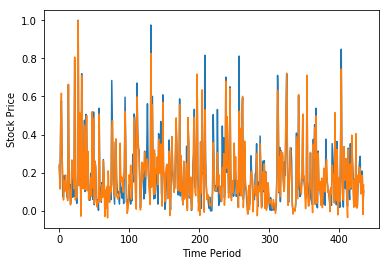

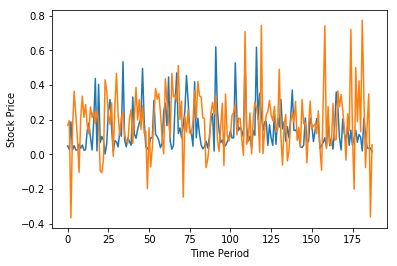

In [13]:
tf.reset_default_graph()

train_size = int(len(dataY)*0.7)
test_size = len(dataY) - train_size

trainX, testX = np.array(dataX[:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[:train_size]), np.array(dataY[train_size:len(dataY)])

X = tf.placeholder(tf.float32, [None, seq_len, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)
print(outputs[:, -1].shape)
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)

loss = tf.reduce_sum(tf.square(Y_pred - Y))
optimizer = tf.train.AdamOptimizer(0.02)
train = optimizer.minimize(loss)

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess :
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in range(iterations) :
        _, step_loss = sess.run([train, loss], feed_dict = {X:trainX,Y:trainY})
        print("Step {} - loss : {}".format(i, step_loss))
        
    train_predict = sess.run(Y_pred, feed_dict = {X:trainX})
    train_rmse_val = sess.run(rmse, feed_dict = {targets : trainY, predictions : train_predict})
    print("RMSE : {}".format(train_rmse_val))
    test_predict = sess.run(Y_pred, feed_dict = {X:testX})
    rmse_val = sess.run(rmse, feed_dict = {targets : testY, predictions:test_predict})
    print("RMSE : {}".format(rmse_val))
    
    plt.plot(trainY)
    plt.plot(train_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

# Linear Model

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
num_lm_variables = seq_len * len(variable_list)
lm_trainX = np.reshape(trainX, (-1, num_lm_variables))
lm_trainY = np.reshape(trainY, (-1, 1))
lm_testX = np.reshape(testX, (-1, num_lm_variables))
lm_testY = np.reshape(testY, (-1, 1))

In [16]:
lm_trainX.shape

(436, 10)

In [17]:
lm = LinearRegression(fit_intercept=True, normalize=False, copy_X=True)
lm.fit(lm_trainX, lm_trainY)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
lm_train_pred = lm.predict(lm_trainX)
lm_test_pred = lm.predict(lm_testX)

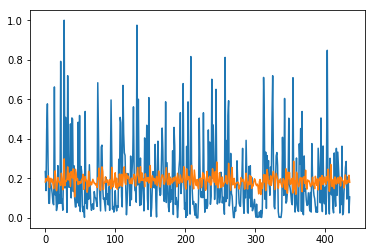

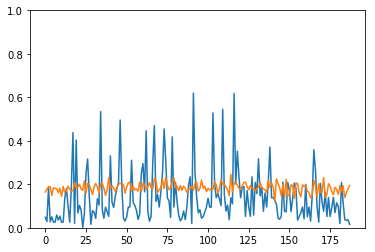

In [19]:
plt.plot(lm_trainY)
plt.plot(lm_train_pred)
plt.show()
    
plt.plot(lm_testY)
plt.plot(lm_test_pred)
plt.ylim(0, 1)
plt.show()

In [20]:
def rmse(target, pred):
    result = np.sqrt(np.mean(np.square(target - pred)))
    return result

In [21]:
train_rmse = rmse(lm_trainY, lm_train_pred)
test_rmse = rmse(lm_testY, lm_test_pred)
print(train_rmse)
print(test_rmse)

0.17876708961293747
0.12745337740301702


# Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
df.head()

,Date,KOSPI,KOSDAQ,Average_Temperature,Lowest_Temperature,Highest_temperature,Precipitation,Average_Wind_Speed,Average_Relative_humidity,Daylight_Hours,Cloud_Cover,Duration_of_Fog,Revenue,Fitness,Sports_Center,Gym,Diet,Body,Busan_Sports_Center,Busan_Gym
0,2016-01-04,1918.76,677.79,10.4,7.6,15.2,0.0,2.7,46.3,8.6,0.8,0.0,1200000,1.70885,0.66053,15.25185,69.49203,1.70459,74.50980,54.90196
1,2016-01-05,1930.53,684.07,5.3,3.2,8.1,0.2,3.1,40.9,0.0,7.0,0.0,900000,1.68328,0.54120,11.19918,58.96616,1.35089,20.91503,43.13725
2,2016-01-06,1925.43,687.27,4.8,1.8,9.9,0.0,2.9,34.5,7.7,5.6,0.0,950000,1.99437,0.45597,10.07841,62.38387,1.30827,25.49019,39.86928
3,2016-01-07,1904.33,679.66,3.9,1.1,8.5,0.0,2.7,47.3,8.6,0.9,0.0,880000,1.65771,0.47728,8.82553,63.78164,2.01142,22.87581,42.48366
4,2016-01-08,1917.62,682.56,2.5,-0.5,6.9,0.0,2.9,44.1,9.1,0.8,0.0,450000,1.35941,0.41336,7.26583,57.66641,1.44464,16.99346,24.83660


In [24]:
revenue = np.array(df['Revenue'])
prev_revenue = np.concatenate(([1200000.0], revenue[:-1])).astype(float)
rate = (revenue - prev_revenue) / prev_revenue

In [25]:
df['Increasing_Rate'] = rate

In [26]:
df.head()

,Date,KOSPI,KOSDAQ,Average_Temperature,Lowest_Temperature,Highest_temperature,Precipitation,Average_Wind_Speed,Average_Relative_humidity,Daylight_Hours,...,Duration_of_Fog,Revenue,Fitness,Sports_Center,Gym,Diet,Body,Busan_Sports_Center,Busan_Gym,Increasing_Rate
0,2016-01-04,1918.76,677.79,10.4,7.6,15.2,0.0,2.7,46.3,8.6,...,0.0,1200000,1.70885,0.66053,15.25185,69.49203,1.70459,74.50980,54.90196,0.000000
1,2016-01-05,1930.53,684.07,5.3,3.2,8.1,0.2,3.1,40.9,0.0,...,0.0,900000,1.68328,0.54120,11.19918,58.96616,1.35089,20.91503,43.13725,-0.250000
2,2016-01-06,1925.43,687.27,4.8,1.8,9.9,0.0,2.9,34.5,7.7,...,0.0,950000,1.99437,0.45597,10.07841,62.38387,1.30827,25.49019,39.86928,0.055556
3,2016-01-07,1904.33,679.66,3.9,1.1,8.5,0.0,2.7,47.3,8.6,...,0.0,880000,1.65771,0.47728,8.82553,63.78164,2.01142,22.87581,42.48366,-0.073684
4,2016-01-08,1917.62,682.56,2.5,-0.5,6.9,0.0,2.9,44.1,9.1,...,0.0,450000,1.35941,0.41336,7.26583,57.66641,1.44464,16.99346,24.83660,-0.488636


In [27]:
rate = df['Increasing_Rate']
df['Rate_Class'] = np.where(rate > 0.6, 'very high', 
                            (np.where(rate > 0.3, 'high',
                                     np.where(rate > -0.3, 'moderate',
                                             np.where(rate > -0.6, 'low', 'very low')))))


In [28]:
columns = [x for x in df.columns if x not in ['Date', 'Rate_Class']]
df_subset_scaled = df.copy()
df_subset_scaled[columns] = df_subset_scaled[columns].apply(MinMaxScaler, axis=0)
df_subset_scaled.head()

,Date,KOSPI,KOSDAQ,Average_Temperature,Lowest_Temperature,Highest_temperature,Precipitation,Average_Wind_Speed,Average_Relative_humidity,Daylight_Hours,...,Revenue,Fitness,Sports_Center,Gym,Diet,Body,Busan_Sports_Center,Busan_Gym,Increasing_Rate,Rate_Class
0,2016-01-04,0.115513,0.459785,0.388889,0.438692,0.412281,0.000000,0.010223,0.461224,0.089304,...,0.255834,0.293963,0.110771,0.992950,0.646212,0.432920,0.767606,0.951220,0.006933,moderate
1,2016-01-05,0.131799,0.487909,0.239766,0.318801,0.204678,0.001675,0.011738,0.406122,0.000000,...,0.191608,0.286088,0.082052,0.657737,0.515434,0.339347,0.190141,0.731707,0.005147,moderate
2,2016-01-06,0.124742,0.502239,0.225146,0.280654,0.257310,0.000000,0.010981,0.340816,0.079958,...,0.202312,0.381889,0.061539,0.565034,0.557897,0.328071,0.239437,0.670732,0.007329,moderate
3,2016-01-07,0.095546,0.468159,0.198830,0.261580,0.216374,0.000000,0.010223,0.471429,0.089304,...,0.187326,0.278214,0.066667,0.461403,0.575263,0.514093,0.211268,0.719512,0.006406,moderate
4,2016-01-08,0.113935,0.481146,0.157895,0.217984,0.169591,0.000000,0.010981,0.438776,0.094496,...,0.095269,0.186352,0.051283,0.332393,0.499285,0.364149,0.147887,0.390244,0.003443,low


In [29]:
dataX = []
dataY = []
for i in range(df_subset_scaled.shape[0] - seq_len):
    _x = df_subset_scaled.loc[i:i+seq_len-1, variable_list].values
    _y = df_subset_scaled.loc[i+seq_len, ['Rate_Class']].values
    dataX.append(_x)
    dataY.append(_y)

train_size = int(len(dataY)*0.7)
test_size = len(dataY) - train_size

trainX, testX = np.array(dataX[:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[:train_size]), np.array(dataY[train_size:len(dataY)])

num_lm_variables = seq_len * len(variable_list)
dt_trainX = np.reshape(trainX, (-1, num_lm_variables))
dt_trainY = np.reshape(trainY, (-1, 1))
dt_testX = np.reshape(testX, (-1, num_lm_variables))
dt_testY = np.reshape(testY, (-1, 1))

In [30]:
print(dt_trainX)
print(dt_trainY)

[[0.38888889 0.25583387 0.23976608 ... 0.18732605 0.15789474 0.09526868]
 [0.23976608 0.19160779 0.2251462  ... 0.09526868 0.19590643 0.23442518]
 [0.2251462  0.20231214 0.19883041 ... 0.23442518 0.21637427 0.13808606]
 ...
 [0.64035088 0.18090345 0.60233918 ... 0.09526868 0.64619883 0.13808606]
 [0.60233918 0.25583387 0.60233918 ... 0.13808606 0.73976608 0.20873475]
 [0.60233918 0.28580604 0.60233918 ... 0.20873475 0.7251462  0.02526226]]
[['very high']
 ['low']
 ['very high']
 ['moderate']
 ['low']
 ['very low']
 ['moderate']
 ['very high']
 ['moderate']
 ['moderate']
 ['moderate']
 ['low']
 ['moderate']
 ['very high']
 ['very low']
 ['moderate']
 ['very low']
 ['high']
 ['very high']
 ['very low']
 ['very high']
 ['low']
 ['very high']
 ['very low']
 ['moderate']
 ['low']
 ['very high']
 ['very high']
 ['very low']
 ['very high']
 ['low']
 ['very low']
 ['very high']
 ['very low']
 ['low']
 ['very high']
 ['very high']
 ['very low']
 ['very high']
 ['moderate']
 ['very low']
 ['very

In [31]:
dt = DecisionTreeClassifier()
dt.fit(dt_trainX, dt_trainY)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [32]:
print(dt.predict(dt_testX))
print(dt_testY.reshape((-1)))

['moderate' 'very low' 'moderate' 'very low' 'low' 'very high' 'very high'
 'low' 'very high' 'very high' 'very high' 'very high' 'low' 'high' 'high'
 'high' 'very high' 'very low' 'low' 'moderate' 'low' 'very high'
 'very high' 'very low' 'very high' 'very high' 'moderate' 'very high'
 'moderate' 'very high' 'moderate' 'moderate' 'moderate' 'very low'
 'moderate' 'very low' 'low' 'high' 'very high' 'moderate' 'very high'
 'moderate' 'very low' 'high' 'very high' 'very high' 'very high'
 'very low' 'very low' 'very high' 'very high' 'moderate' 'very high'
 'moderate' 'low' 'very low' 'low' 'very low' 'very high' 'very high'
 'moderate' 'very high' 'very low' 'very low' 'very high' 'very high'
 'very high' 'moderate' 'low' 'very low' 'moderate' 'very high'
 'very high' 'moderate' 'moderate' 'very high' 'moderate' 'moderate' 'low'
 'very low' 'very high' 'moderate' 'high' 'low' 'very high' 'moderate'
 'very high' 'low' 'very high' 'very low' 'low' 'very high' 'very low'
 'moderate' 'low'

In [33]:
dt_trainY

array([['very high'],
       ['low'],
       ['very high'],
       ['moderate'],
       ['low'],
       ['very low'],
       ['moderate'],
       ['very high'],
       ['moderate'],
       ['moderate'],
       ['moderate'],
       ['low'],
       ['moderate'],
       ['very high'],
       ['very low'],
       ['moderate'],
       ['very low'],
       ['high'],
       ['very high'],
       ['very low'],
       ['very high'],
       ['low'],
       ['very high'],
       ['very low'],
       ['moderate'],
       ['low'],
       ['very high'],
       ['very high'],
       ['very low'],
       ['very high'],
       ['low'],
       ['very low'],
       ['very high'],
       ['very low'],
       ['low'],
       ['very high'],
       ['very high'],
       ['very low'],
       ['very high'],
       ['moderate'],
       ['very low'],
       ['very high'],
       ['very low'],
       ['low'],
       ['moderate'],
       ['very high'],
       ['very low'],
       ['very high'],
       ['very low']

# Save to excel

In [34]:
import openpyxl

In [35]:
df.to_excel('df.xlsx', sheet_name='sheet1', index=False)
df_subset_scaled.to_excel('scaled_df.xlsx', sheet_name='sheet1', index=False)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/io/excel.py:784: DeprecationWarning: Call to deprecated function remove_sheet (Use wb.remove(worksheet) or del wb[sheetname]).
  self.book.remove_sheet(self.book.worksheets[0])
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-05-30 19:55:40.124812. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [112]:
np.array(df['Rate_Class'])

array(['moderate', 'moderate', 'moderate', 'moderate', 'low', 'very high',
       'low', 'very high', 'moderate', 'low', 'very low', 'moderate',
       'very high', 'moderate', 'moderate', 'moderate', 'low', 'moderate',
       'very high', 'very low', 'moderate', 'very low', 'high',
       'very high', 'very low', 'very high', 'low', 'very high',
       'very low', 'moderate', 'low', 'very high', 'very high',
       'very low', 'very high', 'low', 'very low', 'very high',
       'very low', 'low', 'very high', 'very high', 'very low',
       'very high', 'moderate', 'very low', 'very high', 'very low',
       'low', 'moderate', 'very high', 'very low', 'very high',
       'very low', 'very high', 'very low', 'very high', 'moderate',
       'very low', 'low', 'very high', 'very low', 'very high',
       'very low', 'very high', 'very low', 'very high', 'low',
       'very high', 'low', 'low', 'low', 'very high', 'moderate', 'low',
       'very high', 'moderate', 'moderate', 'moderate', 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-05-11 01:06:29.713108. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [124]:
df['Rate_Class'].value_counts()

very high    196
very low     138
moderate     132
low          124
high          39
Name: Rate_Class, dtype: int64

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-05-11 01:14:07.375068. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
